# Atari mit DQN

<img src="atari_pong.gif" alt="Atari Pong" height="75%"/>

## Vorverarbeitung für Atari Environments
Im Gegensatz zur Aufgabe 3 besteht die Observation in dieser Aufgabe aus gerenderten Pixeldaten aus dem Atari Simulator. Um diese sinnvoll und effizient für das Training der Q-Funktion im Neuronalen Netz verwenden zu können, wird eine Reihe von Vorverarbeitungsschritten ausgeführt. Zusätzlich zu diesen gibt es weitere Vorverarbeitungsschritte, um mit Eigenheiten der Atari Environments umzugehen. Diese Schritte sind nachfolgend genauer erklärt und bereits in den Methoden `make_atari` und `wrap_deepmind` als `gym.Wraper` um das eigentliche Environment implementiert.
### No-ops after Reset
Die ersten 30 Frames pro Episode werden übersprungen. Diese bieten keinen Informationsgehalt, da z.B. bei Pong der Ball sich zu Beginn der Episode zuerst in Richtung Gegner bewegt. Somit ist die Aktionswahl des Agenten in diesem Zeitfenster irrelevant. Für den Agenten beginnt das Spiel mit dem 31sten Frame.
### Max and Skip
Eine vom Agenten gewählte Aktion wird für vier aufeinanderfolgende Frames ausgeführt. Von diesen vier Frames wird das Maximum der Helligkeitswerte der Pixel gebildet und als Observation vom Environment zurückgegeben. Der Grund für diese Vorgehensweise ist ein Darstellungseigenheit bei den Atari Spielen. So kann es z.B. sein, dass bei Pong der Ball von einem Frame auf den nächsten nicht mehr zu sehen ist, da er sich in einem ungünstigen Winkel schräg bewegt und somit nicht mehr vollständig gerendert wird.
### Episodic Life
Mit jedem Leben das der Agent verliert endet eine Episode, das Zurücksetzen des Environments passiert jedoch nur bei einem echten Game Over. Dadurch können alle Game States weiterhin erreicht werden, trotz des Episodic Tasks auf Basis der einzelnen Leben des Agenten.
### Fire Reset
Eine Eigenheit bei den Atari Spielen ist es, dass nach dem Zurücksetzen des Environments die `FIRE`-Taste als Aktion getätigt werden muss, um einen Neustart des Spiels zu initialisieren. Diese "Schwierigkeit" wurde zugunsten eines schnelleren Trainings entfernt, indem zu Spielbeginn die `FIRE`-Taste automatisch als erste Aktion gedrückt wird.
### Warp Frame
In dem ursprünglichen Paper von DeepMind wurde vorgeschlagen, das Inputbild auf 84x84 Pixel zu skalieren. Zusätzlich wird das Bild in Graustufen konvertiert. Damit wird der State-Space von 210x160x3 auf 84x84x1 Pixel reduziert und entsprechend das Lernen beschleunigt.
### Clip Reward
Je nach Atari Spiel können die Rewards unterschiedlich ausfallen. Um diese zu vereinheitlichen wird die Reward Funktion so fixiert, dass bei einer Niederlage -1, bei einem Sieg +1 und ansonsten 0 als Reward vom Environment zurückgegeben wird.
### Framestack
Damit der Agent Bewegungen im Spiel als solche erkennen kann, wird die Observation erweitert. Statt nur dem aktuellen Frame, werden die letzten vier Frames zurückgegeben.

## Model Structure
Dem Netzwerk wird ein State $s$ des Environments übergeben und das Netzwerk gibt wiederum den Q-Wert für jede Aktion, die aus diesem Zustand heraus durchgeführt werden können, aus. Implementierungsdetail (**nicht in Abbildung dargestellt**): Die _action mask_ bildet einen weiteren Input für das Netzwerk (dient allerdings nur der Beschleunigung) und wird mit dem output multiplizert.

<img src="atari_model_structure.svg" alt="Model Structure" width="100%"/>

## Aufgabe 4
Löse das PongNoFrameskip-v4 Environment mittels DQN.

In [1]:
%run ../setup.ipynb

In [16]:
import time
from datetime import datetime
import numpy as np
from contextlib import suppress
from lib.loggers import TensorBoardLogger, tf_summary_image

def interact_with_environment(env, agent, n_episodes=600, max_steps=1000000, train=True, verbose=True):      
    statistics = []
    tb_logger = TensorBoardLogger(f'./logs/run-{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}')
    
    with suppress(KeyboardInterrupt):
        total_step = 0
        for episode in range(n_episodes):
            done = False
            episode_reward = 0
            state = env.reset()
            episode_start_time = time.time()
            episode_step = 0

            while not done:
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)

                if train:
                    agent.train((state, action, next_state, reward, done))

                if episode == 0:
                    # for debug purpose log every state of first episode
                    for obs in state:
                        tb_logger.log_image(f'state_t{episode_step}:', tf_summary_image(np.array(obs, copy=False)),
                                            global_step=total_step)
                state = next_state
                episode_reward += reward
                episode_step += 1
            
            total_step += episode_step

            if episode % 10 == 0:
                speed = episode_step / (time.time() - episode_start_time)
                tb_logger.log_scalar('score', episode_reward, global_step=total_step)
                tb_logger.log_scalar('epsilon', agent.epsilon, global_step=total_step)
                tb_logger.log_scalar('speed', speed, global_step=total_step)
                if verbose:
                    print(f'episode: {episode}/{n_episodes}, score: {episode_reward}, steps: {episode_step}, '
                          f'total steps: {total_step}, e: {agent.epsilon:.3f}, speed: {speed:.2f} steps/s')

            statistics.append({
                'episode': episode,
                'score': episode_reward,
                'steps': episode_step
            })
                                  
            if total_step >= max_steps:
                break
        
    return statistics

In [10]:
!pip list


Package              Version            
-------------------- -------------------
absl-py              0.8.1              
astor                0.8.0              
atari-py             0.2.6              
attrs                19.3.0             
backcall             0.1.0              
bleach               3.1.0              
box2d-py             2.3.8              
certifi              2019.11.28         
chardet              3.0.4              
cycler               0.10.0             
decorator            4.4.1              
defusedxml           0.6.0              
entrypoints          0.3                
future               0.18.2             
gast                 0.3.2              
grpcio               1.16.1             
gym                  0.12.0             
gym-super-mario-bros 7.2.3              
h5py                 2.9.0              
idna                 2.8                
importlib-metadata   1.2.0              
ipykernel            5.1.3              
ipython         

### 4.1
Implementiere in **agent.py** einen Agenten, der in der Lage ist das Environment zu lösen.

NoopResetEnv (max 30) wrapper is used.
MaxAndSkipEnv wrapper is used.
EpisodicLifeEnv wrapper is used.
FireResetEnv wrapper is used.
ClipRewardEnv wrapper is used.
FrameStack (4) wrapper is used.
84
episode: 0/600, score: -20.0, steps: 925, total steps: 925, e: 1.000, speed: 377.21 steps/s
episode: 10/600, score: -20.0, steps: 899, total steps: 9935, e: 1.000, speed: 763.16 steps/s
episode: 20/600, score: -21.0, steps: 784, total steps: 19266, e: 0.908, speed: 34.84 steps/s
episode: 30/600, score: -19.0, steps: 1063, total steps: 28608, e: 0.816, speed: 32.11 steps/s
episode: 40/600, score: -18.0, steps: 1106, total steps: 39076, e: 0.712, speed: 34.48 steps/s
episode: 50/600, score: -17.0, steps: 1550, total steps: 50520, e: 0.599, speed: 33.63 steps/s
episode: 60/600, score: -20.0, steps: 1070, total steps: 64072, e: 0.465, speed: 32.94 steps/s
episode: 70/600, score: -17.0, steps: 1445, total steps: 76747, e: 0.339, speed: 32.59 steps/s


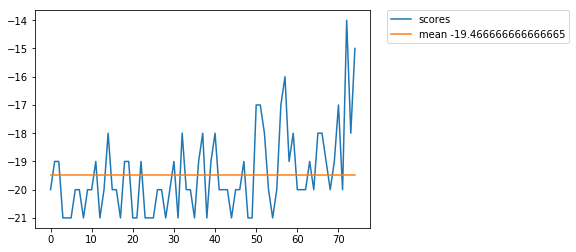

In [22]:
import gym
from lib.statistics import plot
from lib.atari_helpers import wrap_deepmind, make_atari
from agent import AtariDQN
from tensorflow.keras.backend import set_session
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, frame_stack=True)

action_size = env.action_space.n
state_size = env.observation_space.shape[0]
print(state_size)

# Hyperparams
annealing_steps = 100000  # not episodes!
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = (epsilon - epsilon_min) / annealing_steps
alpha = 0.0001
batch_size = 64
memory_size = 10000
start_replay_step = 10000
target_model_update_interval = 1000
train_freq = 4

agent = AtariDQN(action_size=action_size, state_size=state_size, gamma=gamma, 
                 epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, 
                 alpha=alpha, batch_size=batch_size, memory_size=memory_size,
                 start_replay_step=start_replay_step, 
                 target_model_update_interval=target_model_update_interval, train_freq=train_freq)
statistics = interact_with_environment(env, agent, verbose=True)
env.close()#
plot(statistics)

#### **Aufbau Keras Modell**
Der Aufbau des Keras-Modells kann zur Verdeutlichung nochmals geplottet werden.

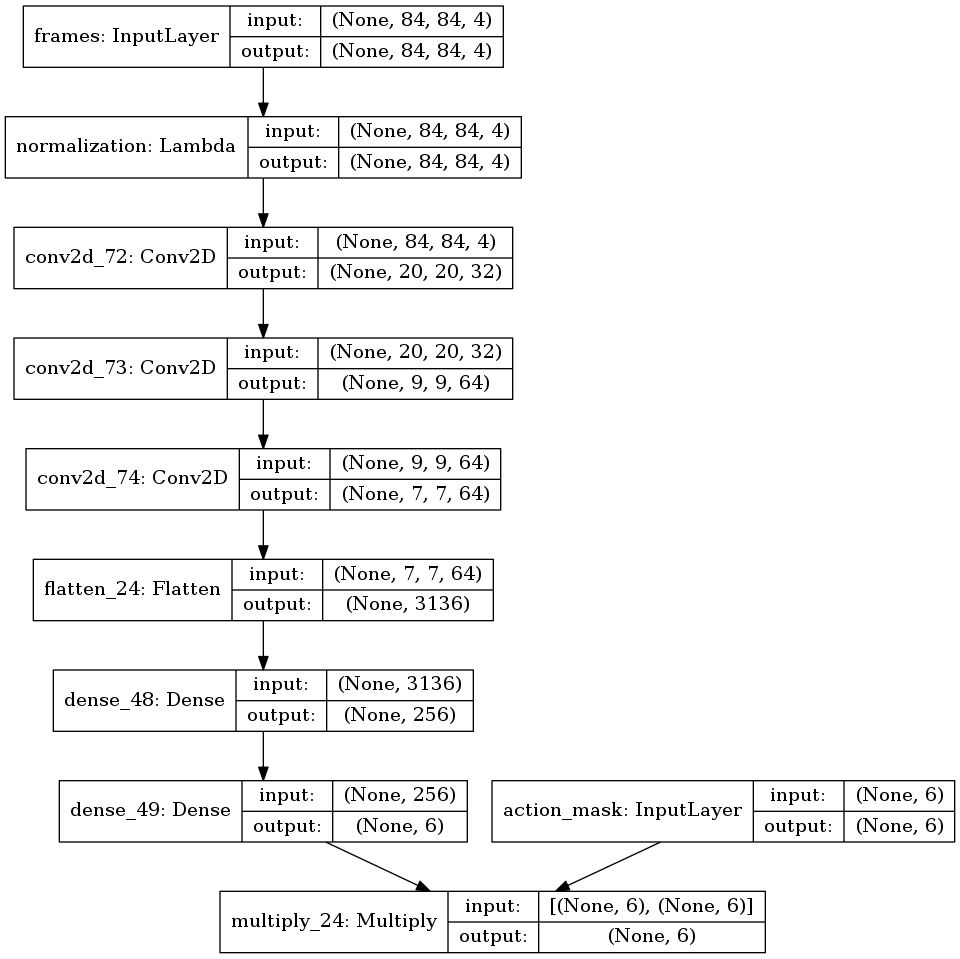

In [23]:
import IPython
import tensorflow as tf
tf.keras.utils.plot_model(agent.model, to_file='keras_plot_model.png', show_shapes=True)
IPython.display.Image('keras_plot_model.png')

#### **Performanceauswertung (Video)**
Der folgende Code dient zur Performancebewertung des Agenten. Der (hoffentlich) trainierte Agent wird bei seiner Ausführung gefilmt, trainiert aber nicht weiter. Anschließend wird das Video seiner besten Performance dargestellt.

NoopResetEnv (max 30) wrapper is used.
MaxAndSkipEnv wrapper is used.
EpisodicLifeEnv wrapper is used.
FireResetEnv wrapper is used.
ClipRewardEnv wrapper is used.
FrameStack (4) wrapper is used.


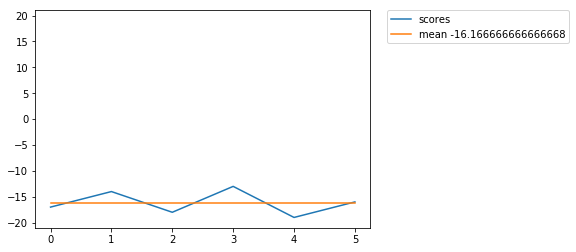

In [24]:
from gym.wrappers import Monitor
from lib.atari_helpers import wrap_deepmind, make_atari
from lib.statistics import html_video_embedding

# capture every episode and clean 'video' folder before each run
env = make_atari('PongNoFrameskip-v4')
env = Monitor(env, './video', video_callable=lambda episode_id: True, force=True, uid='id')
env = wrap_deepmind(env, frame_stack=True)
statistics = interact_with_environment(env, agent, n_episodes=10, train=False, verbose=False)
env.close()

plot(statistics, y_limits=(-21,21))
html_video_embedding(statistics)